# Source finding

## 1. Initialisation

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from time import time
from scipy import stats
import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded
> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

## 2. Read data

In [2]:
importlib.reload(scripts.read_data)
object_name, data, wcs = scripts.read_data.run(22, (0, 0, 1))

Read dataset 22: "NGC2420" (200, 200) (0.0572 s)


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## 3. Sort data

In [3]:
importlib.reload(scripts.sort_data)
argsorted_data, n_valid = scripts.sort_data.run(data.ravel())

Sorted 39592 finite measurements in ascending order (0.00349 s)


## 4. Hierarchical Overdensity Tree (HOT)

In [4]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(data.strides)//data.itemsize, data.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(data, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

HOT: 7929 overdensities found, 39592 "pixels" (98%), 1 independent regions
     3.21 seconds


In [5]:
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
#max_test_stat = catalog[3]

## 5. Reliability

24 sources (0.00162 s)


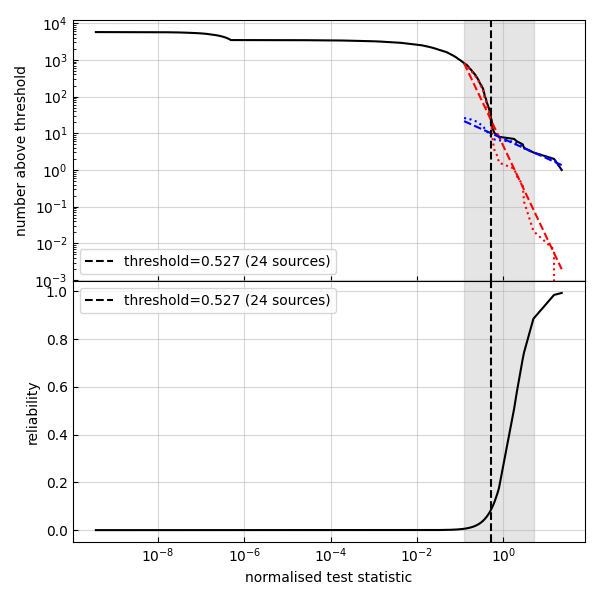

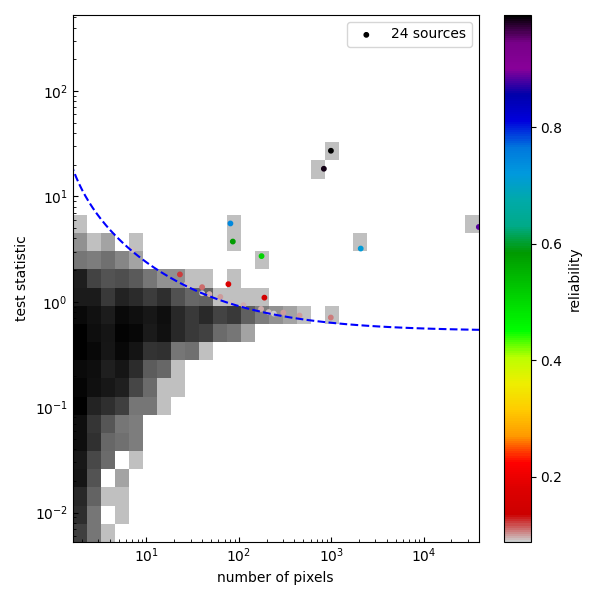

In [6]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(test_stat, area, plots=True)

In [7]:
true_overdensity = reliability > 0
n_sources = np.count_nonzero(true_overdensity)
print(f'{n_sources} potential sources found')

24 potential sources found


## 6. Clean-up

In [8]:
importlib.reload(scripts.cleanup)
label, old_label = scripts.cleanup.run(label, parent, area, true_overdensity, plots=True)

Prune HOT...
 7906 yet to go
 5290 yet to go
 1870 yet to go
 263 yet to go
 12 yet to go
 1 yet to go
... and rename labels
25 objects, 0.00107 seconds


## 7. Compute weights

In [9]:
def compute_weight(object_label):
    target = np.where((label == object_label) & (np.isfinite(data)))
    n_target = target[0].size

    weight = np.zeros_like(data)
    if n_target <= 1:
        print(f'> WARNING: object {object_label} is empty')
        return weight
    weight[target] = data[target]
    background = np.min(weight[target])
    weight[target] -= background
    norm = np.nansum(weight)
    print(f'object {object_label}: {n_target} pixels, flux={norm:.3g} ({100*norm/background/n_target:.3g}% of background={background:.3g})')

    weight = np.fft.rfftn(weight)
    weight = np.fft.irfftn(weight*np.absolute(weight)/norm)
    weight[weight < -np.min(weight)] = 0
    weight /= np.nansum(weight)
    weight *= norm+background*n_target

    '''
    decreasing_weight = np.argsort(weight.flat)[::-1]
    weight.flat[decreasing_weight[:n_target]] += data.flat[decreasing_weight[:n_target]] - background
    weight[np.isnan(weight)] = 0
    weight[weight < 0] = 0
    '''

    return weight

In [10]:
t0 = time()
total_weight = np.zeros_like(data)
primary_label = np.zeros_like(label)
secondary_label = np.zeros_like(label)
max_weight = np.zeros_like(data)
second_weight = np.zeros_like(data)
for lbl in np.unique(label):
    if lbl % 100 == 0:
        print(lbl)
    weight = compute_weight(lbl)
    total_weight += weight

    update = np.where(weight > second_weight)
    secondary_label[update] = lbl
    second_weight[update] = weight[update]
    
    update = np.where(weight > max_weight)
    secondary_label[update] = primary_label[update]
    primary_label[update] = lbl
    second_weight[update] = max_weight[update]
    max_weight[update] = weight[update]

total_background = np.nanmean(data)-np.nanmean(total_weight)
#total_weight += total_background
print(f"Background level: {total_background:.3g} ({100*total_background/np.nanmean(data):.3g}% of the flux) {time()-t0:.3g} seconds")

0
object 0: 32741 pixels, flux=9.02e+05 (30.7% of background=89.8)
object 1: 1963 pixels, flux=4.69e+03 (2.04% of background=117)
object 2: 818 pixels, flux=2.08e+03 (2.14% of background=119)
object 3: 989 pixels, flux=1.12e+03 (0.967% of background=117)
object 4: 809 pixels, flux=1.81e+03 (1.9% of background=118)
object 5: 370 pixels, flux=425 (0.978% of background=117)
> WARNING: object 6 is empty
object 7: 303 pixels, flux=353 (0.985% of background=118)
object 8: 239 pixels, flux=277 (0.977% of background=119)
object 9: 210 pixels, flux=263 (1.05% of background=119)
object 10: 112 pixels, flux=119 (0.907% of background=117)
object 11: 176 pixels, flux=269 (1.3% of background=117)
object 12: 174 pixels, flux=205 (0.991% of background=119)
object 13: 112 pixels, flux=129 (0.969% of background=119)
object 14: 86 pixels, flux=192 (1.91% of background=117)
object 15: 84 pixels, flux=103 (1.04% of background=118)
object 16: 81 pixels, flux=177 (1.84% of background=118)
object 17: 77 pixel

In [11]:
def update_weight(object_label):
    target = np.where(((primary_label == object_label) | (secondary_label == object_label)) & (np.isfinite(data)))
    n_target = target[0].size

    weight = np.zeros_like(data)
    if n_target  <= 1:
        print(f'> WARNING: object {object_label} is empty')
        return weight
    weight[target] = data[target] * compute_weight(object_label)[target]/total_weight[target]
    background = np.min(weight[target])
    weight[target] -= background
    weight[weight < 0] = 0
    norm = np.sum(weight)
    print(f'>     now {n_target} pixels, flux={norm:.3g}, background={background:.3g}')

    weight = np.fft.rfftn(weight)
    weight = np.fft.irfftn(weight*np.absolute(weight)/norm)
    weight[weight < -np.min(weight)] = 0
    '''
    weight[target] += data[target]-background
    weight[np.isnan(weight)] = 0
    '''
    
    '''
    #weight_inside = np.nansum(weight[target])/norm
    decreasing_weight = np.argsort(weight.flat)[::-1]
    weight_inside = np.nansum(weight.flat[decreasing_weight[:n_target]])/norm
    print(f'object {object_label}: {n_target} pixels, flux={norm} ({100*weight_inside:.1f}% inside)')
    
    weight *= 1-weight_inside
    #weight.flat[decreasing_weight[:n_target]] += np.sort(data[target])[::-1]*weight_inside
    #weight.flat[decreasing_weight[:n_target]] += np.sort(data.flat[decreasing_weight[:n_target]])[::-1]*weight_inside
    weight.flat[decreasing_weight[:n_target]] += (data.flat[decreasing_weight[:n_target]] - background)*weight_inside
    weight[np.isnan(weight)] = 0
    weight[weight < 0] = 0
    '''

    return weight

In [12]:
t0 = time()
new_total_weight = np.zeros_like(data)
'''
'''
new_primary_label = np.zeros_like(label)
new_secondary_label = np.zeros_like(label)
max_weight = np.zeros_like(data)
second_weight = np.zeros_like(data)
for lbl in np.unique(label):
    if lbl % 100 == 0:
        print(lbl)
    weight = update_weight(lbl)
    new_total_weight += weight
    print(f"{np.nanmean(new_total_weight):.3g} {time()-t0:.3g} seconds")
    update = np.where(weight > second_weight)
    new_secondary_label[update] = lbl
    second_weight[update] = weight[update]
    
    update = np.where(weight > max_weight)
    new_secondary_label[update] = new_primary_label[update]
    new_primary_label[update] = lbl
    second_weight[update] = max_weight[update]
    max_weight[update] = weight[update]
'''
'''

#iteration += 1
#total_weight = new_total_weight
#primary_label = new_primary_label
#secondary_label = new_secondary_label
#print(f"iteration {iteration}: {time()-t0:.3g} seconds")
updated_background = np.nanmean(data)-np.nanmean(new_total_weight)
#new_total_weight += updated_background
print(f"Background level: {updated_background:.3g} ({100*updated_background/np.nanmean(data):.3g}% of the flux) {time()-t0:.3g} seconds")

0
object 0: 32741 pixels, flux=9.02e+05 (30.7% of background=89.8)
>     now 39592 pixels, flux=3.23e+06, background=19.7
80.7 0.0093 seconds
object 1: 1963 pixels, flux=4.69e+03 (2.04% of background=117)
>     now 8322 pixels, flux=1.49e+05, background=1.23
84.4 0.0157 seconds
object 2: 818 pixels, flux=2.08e+03 (2.14% of background=119)
>     now 3375 pixels, flux=5.88e+04, background=1.09
85.9 0.0207 seconds
object 3: 989 pixels, flux=1.12e+03 (0.967% of background=117)
>     now 4162 pixels, flux=6.97e+04, background=1.84
87.6 0.0256 seconds
object 4: 809 pixels, flux=1.81e+03 (1.9% of background=118)
>     now 2966 pixels, flux=6.21e+04, background=0.472
89.2 0.03 seconds
object 5: 370 pixels, flux=425 (0.978% of background=117)
>     now 1577 pixels, flux=2.42e+04, background=2.55
89.8 0.0347 seconds
> WARNING: object 6 is empty
89.8 0.036 seconds
object 7: 303 pixels, flux=353 (0.985% of background=118)
>     now 1878 pixels, flux=2.82e+04, background=2.09
90.5 0.0405 seconds
ob

## 8. Explore results

### Definitions

In [28]:
plots = True
data_dimensionality = sorted_strides.size-1
#p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
#colour_scale = colors.SymLogNorm(vmin=p50-3*(p50-p16), linthresh= p50+3*(p50-p16), vmax=p100)
#data_min = data.ravel()[argsorted_data[0]]
#pivot = np.percentile(data[data > 0], 1)
#scale_min = data.ravel()[argsorted_data[int(argsorted_data.size*.01)]]
#pivot = data.ravel()[argsorted_data[int(argsorted_data.size*.5)]]  # median
#scale_max = data.ravel()[argsorted_data[int(argsorted_data.size*.99)]]
#scale_max = data.ravel()[argsorted_data[-1]]
#colour_scale = colors.SymLogNorm(vmin=scale_min, linthresh=2*pivot-scale_min, vmax=scale_max)
p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
colour_scale = colors.SymLogNorm(vmin=0, linthresh=2*p50-p16, vmax=p100)

#colour_scale = colors.SymLogNorm(vmin=0, linthresh=100, vmax=200)

In [29]:
my_cmap = np.vstack([np.argsort(np.random.random(n_sources))/n_sources, np.argsort(np.random.random(n_sources))/n_sources, np.argsort(np.random.random(n_sources))/n_sources, np.ones(n_sources)]).T
final_cmap = colors.ListedColormap(my_cmap)

### Individual objects

object 22: 27 pixels, flux=35.3 (1.13% of background=115)
object 22: 27 pixels, flux=35.3 (1.13% of background=115)
>     now 139 pixels, flux=1.89e+03, background=5.25


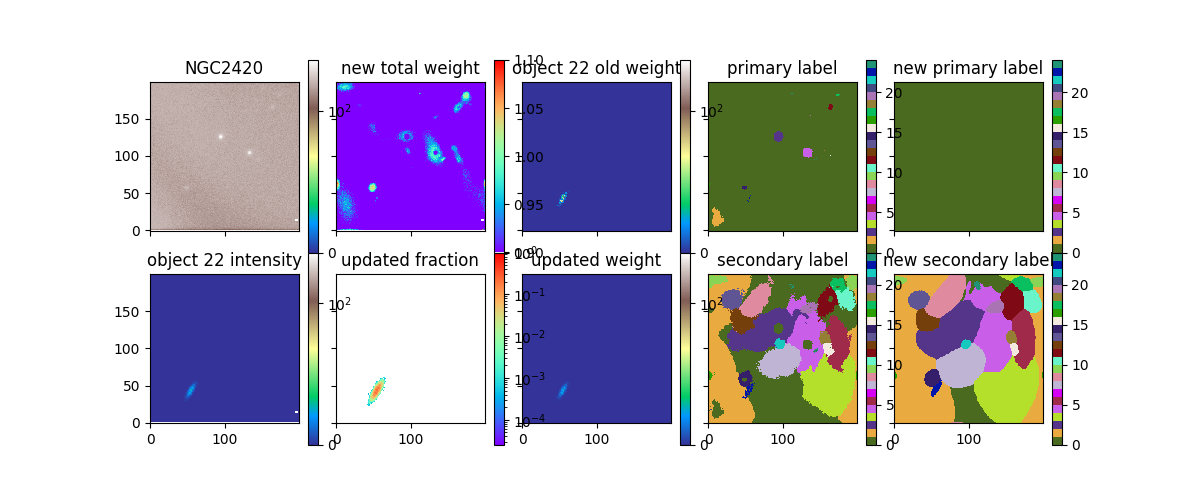

In [30]:
def explore_weight(object_label, data, labels, total_weight, intensity_scale):
    fig_name = 'explore_weight'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 5))
    axes = fig.subplots(nrows=2, ncols=5, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    old_weight = compute_weight(object_label)
    new_weight = update_weight(object_label)
    #model = update_model(object_label, data, label, total_weight)

    ax = axes[0, 0]
    ax.set_title(f'{object_name}')
    im = ax.imshow(
        data,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)
    
    ax = axes[0, 1]
    ax.set_title(f'new total weight')
    im = ax.imshow(
        new_total_weight/data,
        interpolation='nearest', origin='lower',
        cmap='rainbow',
        vmin=0.9, vmax=1.1,
        #cmap='terrain',
        #norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 2]
    '''
    ax.set_title(f'old lables')
    im = ax.imshow(
        label,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    '''
    ax.set_title(f'object {object_label} old weight')
    im = ax.imshow(
        old_weight,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    '''
    ax.set_title(f'object {object_label} background')
    im = ax.imshow(
        data*(1-model/total_model),
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    '''
    cb = fig.colorbar(im, ax=ax)

    ax = axes[1, 0]
    ax.set_title(f'object {object_label} intensity')
    im = ax.imshow(
        data*new_weight/new_total_weight,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    '''
    ax.set_title(f'object {object_label} model')
    im = ax.imshow(
        model,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    '''
    cb = fig.colorbar(im, ax=ax)
    
    ax = axes[1, 1]
    '''
    ax.set_title(f'new weight')
    im = ax.imshow(
        new_weight,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    ax.set_title(f'max weight')
    im = ax.imshow(
        max_weight,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    '''
    ax.set_title(f'updated fraction')
    im = ax.imshow(
        new_weight/new_total_weight,
        interpolation='nearest', origin='lower',
        cmap='rainbow', norm=colors.LogNorm(vmin=1/data.size, vmax=1)
        #vmin=0, vmax=1,
        )
    '''
    ax.set_title(f'fraction')
    im = ax.imshow(
        weight/total_weight,
        interpolation='nearest', origin='lower',
        cmap='rainbow',
        vmin=0, vmax=1,
        )
    im = ax.imshow(
        total_model,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    '''
    cb = fig.colorbar(im, ax=ax)

    ax = axes[1, 2]
    '''
    ax.set_title(f'HOT labels')
    im = ax.imshow(
        label,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_sources, cmap=final_cmap,
        )
    '''
    ax.set_title(f'updated weight')
    im = ax.imshow(
        new_weight,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 3]
    ax.set_title(f'primary label')
    im = ax.imshow(
        primary_label,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_sources, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 4]
    ax.set_title(f'new primary label')
    im = ax.imshow(
        new_primary_label,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_sources, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[1, 3]
    ax.set_title(f'secondary label')
    im = ax.imshow(
        secondary_label,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_sources, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[1, 4]
    ax.set_title(f'new secondary label')
    im = ax.imshow(
        new_secondary_label,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_sources, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)


    
explore_weight(22, data, label, total_weight, colour_scale)

In [27]:
np.unique(primary_label), np.unique(new_primary_label), np.unique(new_secondary_label)

(array([ 0,  1,  2,  4, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24],
       dtype=int32),
 array([0], dtype=int32),
 array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 21, 22, 24], dtype=int32))

In [17]:
'''
def explore_object_2D(object_label, data, labels, intensity_scale):
    target = np.where(label == object_label)
    target_min = np.nanmin(data[target])
    n_target = target[0].size
    index_min = np.min(target, axis=1).astype(int)
    L = np.minimum(data.shape, 2*(np.max(target, axis=1).astype(int) - index_min))
    print(f'> DEBUG: {index_min}-{index_min+L} / {np.max(target, axis=1).astype(int)}: {L} ({data.shape})')
    index_min = np.clip(index_min-L//4, a_min=0, a_max=data.shape-L)
    print(f'> DEBUG: {index_min}-{index_min+L}')

    intensity = np.zeros(L)
    shifted_target = np.ravel_multi_index(target-index_min[:, np.newaxis], intensity.shape)
    intensity.flat[shifted_target] = data[target]
    decreasing_intensity = np.argsort(intensity.flat[shifted_target])[::-1]

    transform = np.fft.rfftn(intensity)
    convolution = np.fft.irfftn(transform*np.absolute(transform))
    decreasing_model = np.argsort(convolution.flat)[::-1]
    convolution *= np.sum(intensity) / np.sum(convolution.flat[decreasing_model[:n_target]])

    model = convolution.copy()
    #model.flat[decreasing_model[:n_target]] = intensity.flat[shifted_target][decreasing_intensity]
    #model.flat[decreasing_model[:n_target]] = np.maximum(model.flat[decreasing_model[:n_target]], intensity.flat[shifted_target][decreasing_intensity])
    convolution_weight = np.arange(n_target)/n_target
    model.flat[decreasing_model[:n_target]] = (
        convolution_weight * model.flat[decreasing_model[:n_target]] + (1-convolution_weight) * intensity.flat[shifted_target][decreasing_intensity])
    

    fig_name = 'explore_object'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 3))    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(f'{object_name} - object {object_label}')
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 1]
    ax.set_title('Self-convolution')
    im = ax.imshow(
        convolution,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 2]
    ax.set_title('Source model')
    im = ax.imshow(
        model,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

    
    fig_name = 'object_intensity_profile'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(6, 3))
    axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.plot(intensity.flat[shifted_target][decreasing_intensity], 'k-')
    ax.plot(convolution.ravel()[decreasing_model], 'b:')
    ax.set_ylabel('Intensity')
    ax.set_yscale('log')
    ax.set_xlabel('pixel')
    ax.set_xscale('log')

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()


if data_dimensionality == 2:
    explore_object_2D(993, data, label, colour_scale)
'''


"\ndef explore_object_2D(object_label, data, labels, intensity_scale):\n    target = np.where(label == object_label)\n    target_min = np.nanmin(data[target])\n    n_target = target[0].size\n    index_min = np.min(target, axis=1).astype(int)\n    L = np.minimum(data.shape, 2*(np.max(target, axis=1).astype(int) - index_min))\n    print(f'> DEBUG: {index_min}-{index_min+L} / {np.max(target, axis=1).astype(int)}: {L} ({data.shape})')\n    index_min = np.clip(index_min-L//4, a_min=0, a_max=data.shape-L)\n    print(f'> DEBUG: {index_min}-{index_min+L}')\n\n    intensity = np.zeros(L)\n    shifted_target = np.ravel_multi_index(target-index_min[:, np.newaxis], intensity.shape)\n    intensity.flat[shifted_target] = data[target]\n    decreasing_intensity = np.argsort(intensity.flat[shifted_target])[::-1]\n\n    transform = np.fft.rfftn(intensity)\n    convolution = np.fft.irfftn(transform*np.absolute(transform))\n    decreasing_model = np.argsort(convolution.flat)[::-1]\n    convolution *= np.s

In [18]:
def intensity_map(data):
    return np.nanstd(data, axis=2)

def explore_object_3D(object_label, data, labels, intensity_scale):
    target = np.where(label == object_label)
    target_min = np.nanmin(data[target])
    n_target = target[0].size
    index_min = np.min(target, axis=1).astype(int)
    L = np.minimum(data.shape, 2*(np.max(target, axis=1).astype(int) - index_min))
    print(f'> DEBUG: {index_min}-{index_min+L} / {np.max(target, axis=1).astype(int)}: {L} ({data.shape})')
    index_min = np.clip(index_min-L//4, a_min=0, a_max=data.shape-L)
    print(f'> DEBUG: {index_min}-{index_min+L}')

    intensity = np.zeros(L)
    shifted_target = np.ravel_multi_index(target-index_min[:, np.newaxis], intensity.shape)
    intensity.flat[shifted_target] = data[target]
    decreasing_intensity = np.argsort(intensity.flat[shifted_target])[::-1]

    transform = np.fft.rfftn(intensity)
    convolution = np.fft.irfftn(transform*np.absolute(transform))
    decreasing_model = np.argsort(convolution.flat)[::-1]
    convolution *= np.sum(intensity) / np.sum(convolution.flat[decreasing_model[:n_target]])

    model = convolution.copy()
    #model.flat[decreasing_model[:n_target]] = intensity.flat[shifted_target][decreasing_intensity]
    #model.flat[decreasing_model[:n_target]] = np.maximum(model.flat[decreasing_model[:n_target]], intensity.flat[shifted_target][decreasing_intensity])
    convolution_weight = np.arange(n_target)/n_target
    model.flat[decreasing_model[:n_target]] = (
        convolution_weight * model.flat[decreasing_model[:n_target]] + (1-convolution_weight) * intensity.flat[shifted_target][decreasing_intensity])
    

    fig_name = 'explore_object'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 3))    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        #gridspec_kw={'hspace': 0, 'wspace': 0}
                       )

    ax = axes[0, 0]
    ax.set_title(f'{object_name} - object {object_label}')
    im = ax.imshow(
        intensity_map(intensity),
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 1]
    ax.set_title('Self-convolution')
    im = ax.imshow(
        intensity_map(convolution),
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 2]
    ax.set_title('Source model')
    im = ax.imshow(
        intensity_map(model),
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

    
    fig_name = 'object_intensity_profile'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(6, 3))
    axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.plot(intensity.flat[shifted_target][decreasing_intensity], 'k-')
    ax.plot(convolution.ravel()[decreasing_model], 'b:')
    ax.set_ylabel('Intensity')
    ax.set_yscale('log')
    ax.set_xlabel('pixel')
    ax.set_xscale('log')

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()


if data_dimensionality == 3:
    explore_object_3D(2, data, label, colors.LogNorm())

### Segmentation

In [19]:
def show_segmentation(intensity, labels, intensity_scale):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 4))
    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 1]
    ax.set_title(object_name)
    im = ax.imshow(
        total_weight,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 2]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        new_label,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    '''
    ax = axes[0, 1]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 2]
    ax.set_title(f'Reliability')
    im = ax.imshow(
        reliability[old_label[labels]],
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

NameError: name 'new_label' is not defined

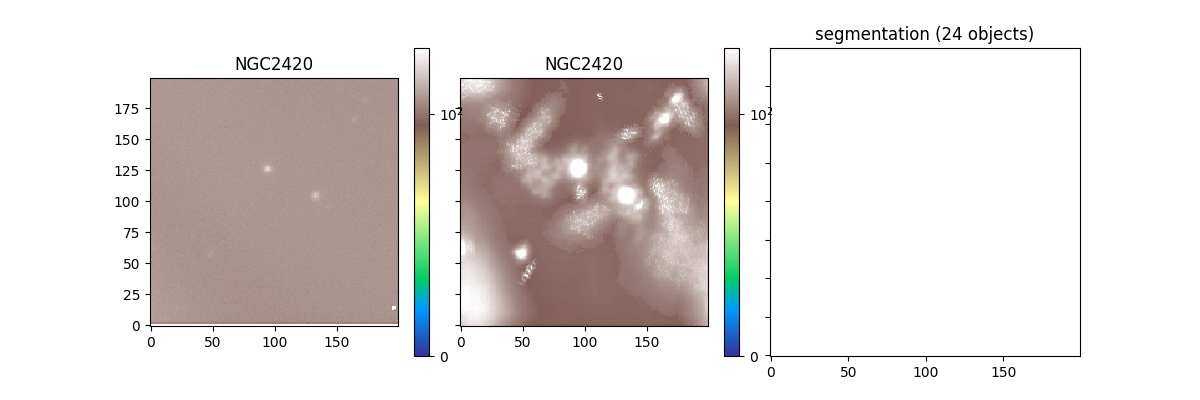

In [20]:
if plots and data_dimensionality == 2:
    show_segmentation(data, label, colour_scale)

elif plots and data_dimensionality == 3:
    intensity = np.nanmean(data**2, axis=1)
    p16, p50 = np.nanpercentile(intensity, [16, 50])
    intensity = (intensity-p50)/(p50-p16)
    #intensity_scale = colors.SymLogNorm(vmin=-3, linthresh=1, vmax=10)
    intensity_scale = colors.Normalize(vmin=-3, vmax=3)
    show_segmentation(intensity, np.nanmax(label, axis=1), intensity_scale)


In [ ]:
'''
if plots and data_dimensionality == 3:

    mode = 0
    
    #boundary = np.zeros_like(max_map)
    #boundary[:, :-1][max_map[:, :-1] != max_map[:, 1:]] = 1
    #boundary[:-1, :][max_map[:-1, :] != max_map[1:, :]] = 1
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(8, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'bottom': .01, 'left': .1, 'top': .99, 'right': .92,
                                   'hspace': .01, 'wspace': .1},
                      subplot_kw={'projection': wcs},
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    #fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    #ax[0, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 1].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[0, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 1].contour(max_map, levels=np.arange(n_sources)+.5, colors='w', linewidths=0.1)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        #(np.sqrt(np.nanmean((data-mode)**2, axis=0)) + np.nanmax(data, axis=0))/2,
        np.nansum(data, axis=0)/np.sqrt(np.nanmean(data**2, axis=0)),
        vmin=0,
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    #ax[0, 1].contour(max_map, levels=[0.5])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_sources} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    #ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        reliability[old_label[max_map]],
        #np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        #vmin=n_reliable/(n_sources+1), vmax=reliability_threshold,
        #cmap='rainbow_r',
        #vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])
'''

In [ ]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('segmentation').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('segmentation').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-mode)
    section_lables = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.max(section_labels, axis=2).T
    horizontal_slit = np.max(section_labels, axis=1).T

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                        )
    #ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    '''
    '''
    for lbl in unique_section_labels[:10]:  # Dirty fix
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
        #(np.nanmax(section, axis=1) + np.sqrt(np.nanmean(section**2, axis=1))).T/2,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #vmin=0,
                         norm=colour_scale,
                        )
    #ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [ ]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


In [ ]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('output/HOT_mask.fits', overwrite=True)
'''
'''
